In [2]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

with open("C:\\Users\\Gaurav\\Desktop\\USC\\Courses\\ML\\HW Submission\\Assignment-4\\gmmdata.txt") as f:
    lines = f.readlines()
    x = [line.split()[0] for line in lines]
    y = [line.split()[1] for line in lines]
    z = [line.split()[2] for line in lines]
X = np.zeros((5000,3))
X[:,0]=np.array(x)
X[:,1]=np.array(y)
X[:,2]=np.array(z)

In [3]:
import numpy as np


class KMeans():

    '''
        Class KMeans:
        Attr:
            n_cluster - Number of cluster for kmeans clustering
            max_iter - maximum updates for kmeans clustering
            e - error tolerance
    '''

    def __init__(self, n_cluster, max_iter=100, e=0.0001):
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.e = e

    def fit(self, x):
        '''
            Finds n_cluster in the data x
            params:
                x - N X D numpy array
            returns:
                A tuple
                (centroids or means, membership, number_of_updates )
            Note: Number of iterations is the number of time you update means other than initialization
        '''
        assert len(x.shape) == 2, "fit function takes 2-D numpy arrays as input"
        np.random.seed(42)
        N, D = x.shape

        # TODO:
        # - comment/remove the exception.
        # - Initialize means by picking self.n_cluster from N data points
        # - Update means and membership untill convergence or untill you have made self.max_iter updates.
        # - return (means, membership, number_of_updates)

        # DONOT CHANGE CODE ABOVE THIS LINE
        mu = x[np.random.randint(0,N,self.n_cluster),:]
        dist = np.zeros((N,self.n_cluster))
        for k in range(self.n_cluster):
            t=(x - mu[k])**2
            dist[:,k] = t.sum(1)
        # membership vector
        R = np.argmin(dist,axis=1)
        # Convert to one-hot encoding
        r = np.zeros((R.size, self.n_cluster))
        r[np.arange(R.size),R] = 1
        # Loss
        dist = dist * r
        J = dist.sum()/N
        for i in range(self.max_iter): 
            # Recompute means
            for k in range(self.n_cluster):
                mu[k] = (r[:,k].reshape(-1,1)*x).sum(0)/r[:,k].sum()
                t=(x - mu[k])**2
                dist[:,k] = t.sum(1)
            # membership vector
            R = np.argmin(dist,axis=1)
            # Convert to one-hot encoding
            r = np.zeros((R.size, self.n_cluster))
            r[np.arange(R.size),R] = 1
            # stopping condition
            dist = dist * r
            if np.abs(J - dist.sum()/N) <= self.e:
                return (mu, R, i+1)
            J = dist.sum()/N
           
        
        return (mu, R, self.max_iter)
            
        # DONOT CHANGE CODE BELOW THIS LINE


class KMeansClassifier():

    '''
        Class KMeansClassifier:
        Attr:
            n_cluster - Number of cluster for kmeans clustering
            max_iter - maximum updates for kmeans clustering
            e - error tolerance
    '''

    def __init__(self, n_cluster, max_iter=100, e=1e-6):
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.e = e

    def fit(self, x, y):
        '''
            Train the classifier
            params:
                x - N X D size  numpy array
                y - N size numpy array of labels
            returns:
                None
            Stores following attributes:
                self.centroids : centroids obtained by kmeans clustering
                self.centroid_labels : labels of each centroid obtained by
                    majority voting
        '''

        assert len(x.shape) == 2, "x should be a 2-D numpy array"
        assert len(y.shape) == 1, "y should be a 1-D numpy array"
        assert y.shape[0] == x.shape[0], "y and x should have same rows"

        np.random.seed(42)
        N, D = x.shape
        # TODO:
        # - comment/remove the exception.
        # - Implement the classifier
        # - assign means to centroids
        # - assign labels to centroid_labels

        # DONOT CHANGE CODE ABOVE THIS LINE
        kmeans = KMeans(self.n_cluster,self.max_iter,self.e)
        centroids, R, _ = kmeans.fit(x)
        centroid_labels = np.zeros(self.n_cluster)
        for k in range(self.n_cluster):
            values, counts = np.unique(y[R==k],return_counts=True)
            centroid_labels[k] = values[np.argmax(counts)]
        # DONOT CHANGE CODE BELOW THIS LINE

        self.centroid_labels = centroid_labels
        self.centroids = centroids

        assert self.centroid_labels.shape == (self.n_cluster,), 'centroid_labels should be a vector of shape {}'.format(
            self.n_cluster)

        assert self.centroids.shape == (self.n_cluster, D), 'centroid should be a numpy array of shape {} X {}'.format(
            self.n_cluster, D)

    def predict(self, x):
        '''
            Predict function

            params:
                x - N X D size  numpy array
            returns:
                predicted labels - numpy array of size (N,)
        '''

        assert len(x.shape) == 2, "x should be a 2-D numpy array"

        np.random.seed(42)
        N, D = x.shape
        # TODO:
        # - comment/remove the exception.
        # - Implement the prediction algorithm
        # - return labels

        # DONOT CHANGE CODE ABOVE THIS LINE
        dist = np.zeros((N,self.n_cluster))
        for k in range(self.n_cluster):
            t=(x - self.centroids[k])**2
            dist[:,k] = t.sum(1)
        R = np.argmin(dist,axis=1)
        return self.centroid_labels[R]
        # DONOT CHANGE CODE BELOW THIS LINE


In [4]:
import numpy as np

def pdf_multivariate(X, mu, s):
    if np.linalg.det(s) == 0:
        s =  s + 1e-3*np.identity(s.shape[0])
    return np.linalg.det(s) ** -0.5 * (2 * np.pi) ** (-X.shape[1]/2.0) \
                * np.exp(-.5 * np.einsum('ij, ij -> i',\
                        X - mu, np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 

class GMM():
    '''
        Fits a Gausian Mixture model to the data.

        attrs:
            n_cluster : Number of mixtures
            e : error tolerance
            max_iter : maximum number of updates
            init : initialization of means and variance
                Can be 'random' or 'kmeans'
            means : means of gaussian mixtures
            variances : variance of gaussian mixtures
            pi_k : mixture probabilities of different component
    '''

    def __init__(self, n_cluster, init='k_means', max_iter=100, e=0.0001):
        self.n_cluster = n_cluster
        self.e = e
        self.max_iter = max_iter
        self.init = init
        self.means = None
        self.variances = None
        self.pi_k = None

    def fit(self, x):
        '''
            Fits a GMM to x.

            x: is a NXD size numpy array
            updates:
                self.means
                self.variances
                self.pi_k
        '''
        assert len(x.shape) == 2, 'x can only be 2 dimensional'

        np.random.seed(42)
        N, D = x.shape

        if (self.init == 'k_means'):
            # TODO
            # - comment/remove the exception
            # - initialize means using k-means clustering
            # - compute variance and pi_k

            # DONOT MODIFY CODE ABOVE THIS LINE
            k_means = KMeans(self.n_cluster,self.max_iter,self.e)
            self.means, R, _ = k_means.fit(x)
            r = np.zeros((R.size, self.n_cluster))
            r[np.arange(R.size),R] = 1
            self.pi_k = np.zeros(self.n_cluster)
            self.variances = np.zeros((self.n_cluster,D,D))
            for k in range(self.n_cluster):
                Nk = (R == k).sum()
                self.pi_k[k] = Nk/N
                m = r[:,k].reshape(-1,1)*(x-self.means[k])
                self.variances[k] = m.T.dot(x-self.means[k]) / Nk

                        
            # DONOT MODIFY CODE BELOW THIS LINE

        elif (self.init == 'random'):
            # TODO
            # - comment/remove the exception
            # - initialize means randomly
            # - compute variance and pi_k

            # DONOT MODIFY CODE ABOVE THIS LINE
            self.pi_k = np.array([1/self.n_cluster for _ in range(self.n_cluster)])
            self.means = x[np.random.randint(0,N,self.n_cluster)]
            self.variances = np.zeros((self.n_cluster,D,D))
            for k in range(self.n_cluster):
                self.variances[k] = np.identity(D)
            # DONOT MODIFY CODE BELOW THIS LINE

        else:
            raise Exception('Invalid initialization provided')

        l = self.compute_log_likelihood(x)

        # TODO
        # - comment/remove the exception
        # - find the optimal means, variances, and pi_k and assign it to self
        # - return number of updates done to reach the optimal values.
        # Hint: Try to seperate E & M step for clarity

        # DONOT MODIFY CODE ABOVE THIS LINE
        for it in range(self.max_iter):
            # E step, get responsibilities
            r = np.zeros((N,self.n_cluster))
            for k in range(self.n_cluster):
                r[:,k] = self.pi_k[k]*pdf_multivariate(x,self.means[k],self.variances[k])
                
            r = (r.T / np.sum(r, axis=1)).T
            
            # M - step
            for k in range(self.n_cluster):
                Nk = r[:,k].sum()
                self.means[k] = (r[:,k].reshape(-1,1) * x).sum(0) / Nk
                m = r[:,k].reshape(-1,1)*(x-self.means[k])
                self.variances[k] = m.T.dot(x-self.means[k]) / Nk
                self.pi_k[k] = Nk/N

            lnew = self.compute_log_likelihood(x)
            if np.abs(l-lnew) <= self.e:
                return it
            l = lnew        
        return self.max_iter
        # DONOT MODIFY CODE BELOW THIS LINE

    def sample(self, N):
        '''
        sample from the GMM model

        N is a positive integer
        return : NXD array of samples

        '''
        assert type(N) == int and N > 0, 'N should be a positive integer'
        np.random.seed(42)
        if (self.means is None):
            raise Exception('Train GMM before sampling')

        # TODO
        # - comment/remove the exception
        # - generate samples from the GMM
        # - return the samples

        # DONOT MODIFY CODE ABOVE THIS LINE
        ks = np.random.choice(self.n_cluster, size=N, p=self.pi_k)
        data = []
        for k in ks:
            data.append(np.random.multivariate_normal(self.means[k],self.variances[k]))
        return np.array(data)
        # DONOT MODIFY CODE BELOW THIS LINE

    def compute_log_likelihood(self, x):
        '''
            Return log-likelihood for the data

            x is a NXD matrix
            return : a float number which is the log-likelihood of data
        '''
        assert len(x.shape) == 2,  'x can only be 2 dimensional'
        # TODO
        # - comment/remove the exception
        # - calculate log-likelihood using means, variances and pi_k attr in self
        # - return the log-likelihood
        # Note: you can call this function in fit function (if required)
        # DONOT MODIFY CODE ABOVE THIS LINE
        N = x.shape[0]
        r =  np.zeros((N,self.n_cluster))
        for k in range(self.n_cluster):
            r[:,k] = self.pi_k[k] * pdf_multivariate(x,self.means[k],self.variances[k]) 
        ll = np.sum(np.log(np.sum(r,axis=1)))
        return float(ll)
        # DONOT MODIFY CODE BELOW THIS LINE


In [9]:

init = ['k_means', 'random']

log_values = np.zeros(25)
c=0
slist=[]

x_train = X
k_val = np.zeros(10)

#x can only be 2 dimensional so i run PCA over z
for i in init:
    for j in range(1,11):
        n_cluster = j
        gmm = GMM(n_cluster=n_cluster, max_iter=1000, init=i, e=1e-10)
        iterations = gmm.fit(x_train)
        ll = gmm.compute_log_likelihood(x_train)
        log_values[(c*10)+j]=ll
        print('GMM for oben dataset with {} initialisation converged in {} iterations for k = {}. Final log-likelihood of data: {}'.format(i, iterations, n_cluster,ll))

        # plot cluster means
        means = gmm.means
    print ("\n")
    c=c+1
    

GMM for oben dataset with k_means initialisation converged in 0 iterations for k = 1. Final log-likelihood of data: -21528.48477466045
GMM for oben dataset with k_means initialisation converged in 47 iterations for k = 2. Final log-likelihood of data: -19718.878752816912
GMM for oben dataset with k_means initialisation converged in 45 iterations for k = 3. Final log-likelihood of data: -19065.628863277878
GMM for oben dataset with k_means initialisation converged in 62 iterations for k = 4. Final log-likelihood of data: -18754.523773428158
GMM for oben dataset with k_means initialisation converged in 39 iterations for k = 5. Final log-likelihood of data: -18420.747424268855
GMM for oben dataset with k_means initialisation converged in 1000 iterations for k = 6. Final log-likelihood of data: -18413.288490269
GMM for oben dataset with k_means initialisation converged in 1000 iterations for k = 7. Final log-likelihood of data: -18405.83936451556
GMM for oben dataset with k_means initialis

In [11]:
listnew=[]
for i in range(10):
    listnew.append(i)
listnew

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
log_values[1:11]

array([-21528.48477466, -19718.87875282, -19065.62886328, -18754.52377343,
       -18420.74742427, -18413.28849027, -18405.83936452, -18396.69242391,
       -18383.54409064, -18376.37030485])

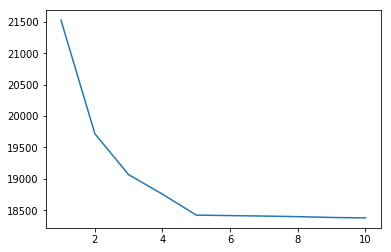

In [26]:
k = list(range(1,11))
plt.plot(k,abs(log_values[1:11]))
plt.show()

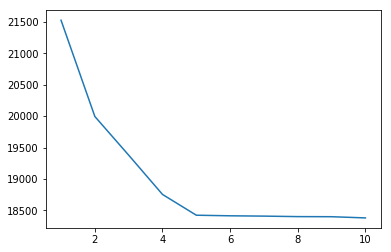

In [27]:
lok = list(range(1,11))
plt.plot(k,abs(log_values[11:21]))
plt.show()

In [ ]:
Therefore we see how in both cases the elbow method shows us that the number of clusters should be 5. 
The lowest point of maximum change.